In [ ]:
import torch 
import numpy as np
from torch import optim,nn 
import torch.nn.functional as F
from torchvision import datasets,transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler 
import matplotlib.pyplot as plt

In [ ]:
X = torch.load('/content/drive/My Drive/data/X.pt')
y = torch.load('/content/drive/My Drive/data/y.pt')

In [ ]:
train_dataset = TensorDataset(X,y)

In [ ]:
valid_size = 0.3

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_dataset,batch_size = 5,sampler=train_sampler)
validloader = DataLoader(train_dataset,batch_size = 5,sampler=valid_sampler)
print(len(trainloader.sampler))
print(len(validloader.sampler))

86
36


In [ ]:
class Unet3D(nn.Module):

    def __init__(self):
        super(Unet3D,self).__init__()

        self.conv1 = nn.Conv3d(in_channels=4,out_channels=32,kernel_size= (3,3,3),stride=(1,1,1),padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64,kernel_size =(3,3,3),stride=(1,1,1),padding=(1,1,1))
        self.maxpool1 = nn.MaxPool3d(kernel_size = (2,2,2))
        self.conv3 = nn.Conv3d(in_channels=64,out_channels=64,kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1))
        self.conv4 = nn.Conv3d(in_channels=64,out_channels=128,kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1))
        self.upsample1 = nn.Upsample(scale_factor = (2,2,2))
        self.conv5 = nn.Conv3d(in_channels=192,out_channels=64,kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1))
        self.conv6 = nn.Conv3d(in_channels=64,out_channels=64,kernel_size=(3,3,3),padding=(1,1,1),stride=(1,1,1))
        self.fconv = nn.Conv3d(in_channels=64,out_channels=3,kernel_size=(1,1,1),stride=(1,1,1))


    def forward(self,x):

        z1 = self.conv1(x)
        a1 = F.relu(z1)

        z2 = self.conv2(a1)
        a2 = F.relu(z2)

        z3 = self.maxpool1(a2)
        z3 = self.conv3(z3)
        a3 = F.relu(z3)

        z4 = self.conv4(a3)
        a4 = F.relu(z4)

        z5 = self.upsample1(a4)
        a5 = torch.cat([z5,a2],dim=1)

        z6 = self.conv5(a5)
        a6 = F.relu(z6)

        z7 = self.conv6(a6)
        a7 = F.relu(z7)

        z8 = self.fconv(a7)
        a8 = F.logsigmoid(z8)

        return a8

In [ ]:
model = Unet3D()
model.cuda()

Unet3D(
  (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (maxpool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (upsample1): Upsample(scale_factor=(2.0, 2.0, 2.0), mode=nearest)
  (conv5): Conv3d(192, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv6): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fconv): Conv3d(64, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)

In [ ]:
def dice_coefficient(y_true,y_pred,axis = (1,2,3),epsilon=(0.00001)):

  dice_numerator = 2. * torch.sum(y_true*y_pred,dim = axis)
  dice_denominator = torch.sum(y_true, dim = axis) + torch.sum(y_pred, dim = axis) + epsilon
  dice_coefficient = torch.mean((dice_numerator)/(dice_denominator))

  return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1,2,3),epsilon = 0.00001):

  dice_numerator = 2. *torch.sum(y_true * y_pred,dim = axis) + epsilon
  dice_denominator = torch.sum(y_true**2,dim = axis) + torch.sum(y_pred**2,dim = axis) + epsilon
  dice_loss = 1 - torch.mean((dice_numerator)/(dice_denominator))
  
  return dice_loss

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([5, 4, 160, 160, 16])
torch.Size([5, 3, 160, 160, 16])


In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 30
train_loss_data = []
val_loss_data = []
train_dice_data = []
val_dice_data = []
valid_loss_min = np.Inf

for epoch in range(epochs):

  train_loss = 0.0
  val_loss = 0.0
  train_dice = 0.0
  val_dice = 0.0

  model.train()
  
  for images,labels in trainloader:

    images = images.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    logps = model(images)
    ps = torch.exp(logps)
    dice_c = dice_coefficient(labels,ps)
    loss = soft_dice_loss(labels,ps)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*images.size(0)
    train_dice += dice_c.item()*images.size(0)


  model.eval()
  with torch.no_grad():
    for images,labels in validloader:

      images = images.cuda()
      labels = labels.cuda()

      logps = model(images)
      ps = torch.exp(logps)
      dice_c = dice_coefficient(labels,ps)
      loss = soft_dice_loss(labels,ps)

      val_loss += loss.item()*images.size(0)
      val_dice += dice_c.item()*images.size(0)

    train_loss = train_loss/len(trainloader.sampler)
    val_loss = val_loss/len(validloader.sampler)
    train_dice = train_dice/len(trainloader.sampler)
    val_dice = val_dice/len(validloader.sampler)

    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)
    train_dice_data.append(train_dice)
    val_dice_data.append(val_dice)

  print("Epoch : {} training Loss : {:.6f} Validation Loss : {:.6f} Train_dice : {:.6f} Val_dice : {:.6f}".format(epoch+1,train_loss,val_loss,train_dice,val_dice))

  if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,val_loss))
        torch.save(model.state_dict(), 'AutoTumourModel.pt')
        valid_loss_min = val_loss

Epoch : 1 training Loss : 0.710074 Validation Loss : 0.597685 Train_dice : 0.200273 Val_dice : 0.257038
Validation loss decreased (inf --> 0.597685).   Saving model ...
Epoch : 2 training Loss : 0.498701 Validation Loss : 0.522764 Train_dice : 0.379341 Val_dice : 0.369056
Validation loss decreased (0.597685 --> 0.522764).   Saving model ...
Epoch : 3 training Loss : 0.460226 Validation Loss : 0.466904 Train_dice : 0.412658 Val_dice : 0.357070
Validation loss decreased (0.522764 --> 0.466904).   Saving model ...
Epoch : 4 training Loss : 0.427202 Validation Loss : 0.442224 Train_dice : 0.440413 Val_dice : 0.475426
Validation loss decreased (0.466904 --> 0.442224).   Saving model ...
Epoch : 5 training Loss : 0.380385 Validation Loss : 0.366969 Train_dice : 0.484320 Val_dice : 0.552981
Validation loss decreased (0.442224 --> 0.366969).   Saving model ...
Epoch : 6 training Loss : 0.330397 Validation Loss : 0.433472 Train_dice : 0.576881 Val_dice : 0.509811
Epoch : 7 training Loss : 0.344

In [ ]:
y_test = model2(torch.unsqueeze(X[32],0))
y_test = torch.exp(y_test)

In [ ]:
y_test = torch.squeeze(y_test,0)
y_test = y_test.cpu().detach().numpy()

In [ ]:
y_actual = y[32]
y_actual = y_actual.numpy()
y_actual.shape

(3, 160, 160, 16)

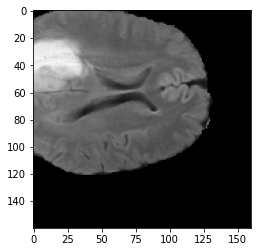

In [ ]:
plt.imshow(X[32][0,:,:,12],cmap = 'gray')

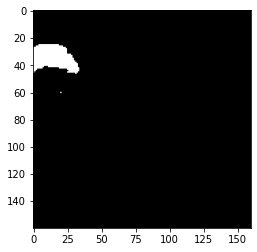

In [ ]:
plt.imshow(y_actual[1,:,:,12],cmap = 'gray')

In [ ]:
y_test[y_test > 0.5] = 1
y_test[y_test <= 0.5] = 0

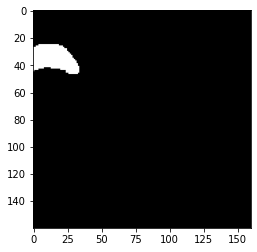

In [ ]:
plt.imshow(y_test[1,:,:,12],cmap = 'gray')